In [157]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2")
%matplotlib inline

## Разведывательный анализ данных

In [158]:
# загружаем данные
data = pd.read_csv('data/data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [160]:
# переводим названяи столбцов в нижний регистр и меняем пробелы на _
data.columns = data.columns.str.lower().str.replace(' ', '_')

# собираем список строковых столбцов
string_col = list(data.dtypes[data.dtypes == 'object'].index)

# в столбцах понижаем регистр, меняем пробелы на _
for col in string_col:
    data[col] = data[col].str.lower().str.replace(' ', '_')

data.head(3)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350


### Анализ целевой переменной

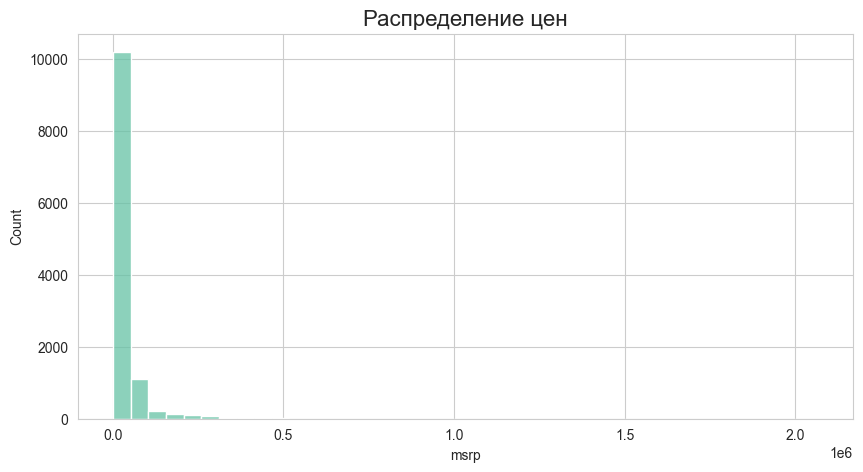

In [161]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data.msrp, bins=40)
ax.set_title('Распределение цен',fontsize=16)
plt.show()

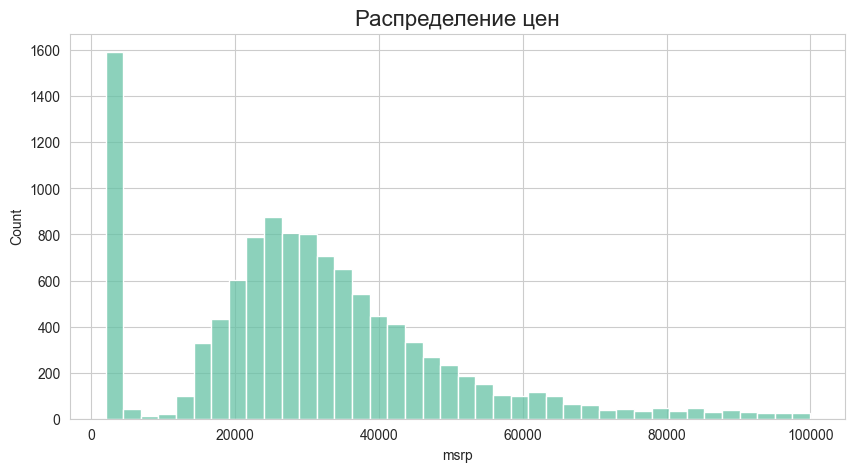

In [162]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data.msrp[data.msrp < 100000], bins=40)
ax.set_title('Распределение цен',fontsize=16)
plt.show()

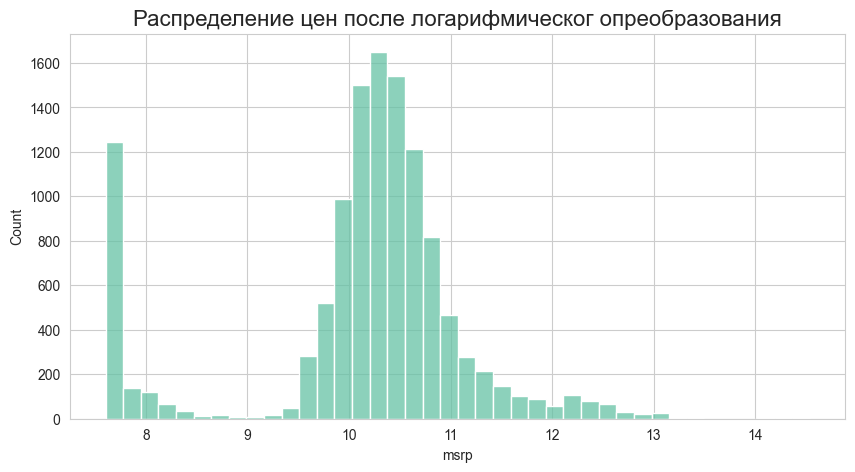

In [163]:
log_prise = np.log1p(data.msrp)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(log_prise, bins=40)
ax.set_title('Распределение цен после логарифмическог опреобразования',fontsize=16)
plt.show()

### Проверка на пропуски

In [164]:
data.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Подготовка данных для проверки

In [165]:
n = len(data)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val+n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

data_shuffled = data.iloc[idx]

data_val = data_shuffled.iloc[:n_val].copy()
data_test = data_shuffled.iloc[n_val:n_val+n_test].copy()
data_train = data_shuffled.iloc[n_val+n_test:].copy()

In [166]:
y_val = np.log1p(data_val['msrp'])
y_test = np.log1p(data_test['msrp'])
y_train = np.log1p(data_train['msrp'])

In [167]:
del data_val['msrp']
del data_test['msrp']
del data_train['msrp']

## Линейная регрессия 

In [ ]:
# вручную напишем функцию линеной регрессии c регуляризацией
def train_linear_regression(X, y, r=0.0):
    # добавляем фиктивный столбец
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # формула нормлаьного уравнения с регуляризацией
    XTX = X.T.dot(X)
    #добавляем к основной диагонали r
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

### Базовое решение 

In [169]:
data.select_dtypes(include=['object']).columns.tolist()

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [ ]:
# выберем признаки на основе которых будем предсказывать цену
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# функция создания матрицы X из датафрейма и преобразования признаков
def prepare_x(df):
    df = df.copy()
    features = base.copy()

    # создадим признак возраста автомобиля(2017 - год создания датасета)
    df['age'] = 2017 - df.year
    features.append('age')

    # кодируем признак кол-ва дверей
    for n in [2, 3, 4]:
        feature = 'number_of_doors%s' % n
        df[feature] = (df['number_of_doors'] == n).astype(int)
        features.append(feature)

    # кодируем признак марки автомобиля
    for m in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % m
        df[feature] = (df['make'] == m).astype(int)
        features.append(feature)

    # кодируем признак типа двигателя
    for t in ['regular_unleaded', 'premium_unleaded_(required)',
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)', 'diesel']:
        feature = 'is_type_%s' % t
        df[feature] = (df['engine_fuel_type'] == t).astype(int)
        features.append(feature)

    # кодируем признак типа трансмиссии
    for tt in ['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown']:
        feature = 'transmission_type_is_%s' % tt
        df[feature] = (df['transmission_type'] == tt).astype(int)
        features.append(feature)

    # кодируем признак кол-ва ведущих колес
    for dw in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % dw
        df[feature] = (df['driven_wheels'] == dw).astype(int)
        features.append(feature)

    # кодируем признак категории маркетинга
    for mc in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_market_category_%s' % mc
        df[feature] = (df['market_category'] == mc).astype(int)
        features.append(feature)

    # кодируем признак размера
    for s in ['compact', 'midsize', 'large']:
        feature = 'is_vehicle_size_%s' % s
        df[feature] = (df['vehicle_size'] == s).astype(int)
        features.append(feature)

    # кодируем стиль
    for st in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_vehicle_style_%s' % st
        df[feature] = (df['vehicle_style'] == st).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0) # избавимся от пропусков - заполним пропуски нулями
    X = df_num.values # преобразовываем датафрейм в NumPy массив
    return X

In [171]:
# преобразуем датасет
X_train = prepare_x(data_train)

# обучаем модель
w_0, w = train_linear_regression(X_train, y_train, 0.01)

# предсказываем цену
y_pred = w_0 + X_train.dot(w)

### Оценка качества модели

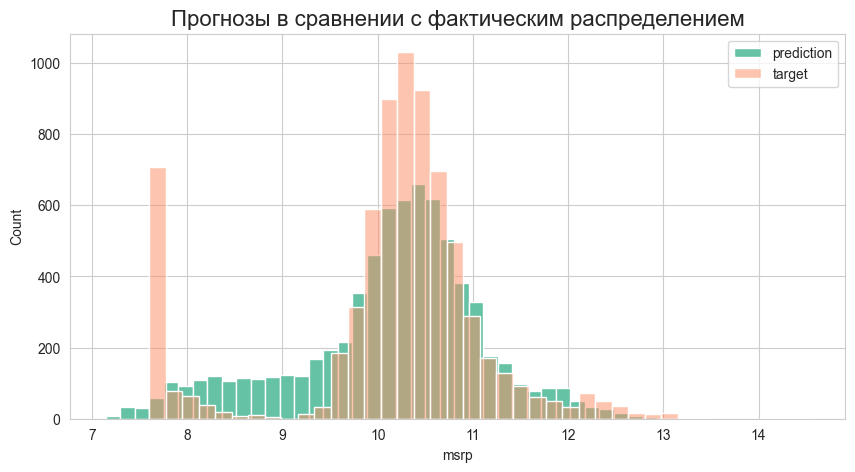

In [172]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(y_pred, bins=40, label='prediction', alpha=1)
sns.histplot(y_train, bins=40, label='target', alpha=0.5)
ax.set_title('Прогнозы в сравнении с фактическим распределением',fontsize=16)
plt.legend()
plt.show()

In [ ]:
# функция метрики RMSE
def RMSE(y, y_pred):
    error = y_pred-y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [174]:
# создаем валидационную матрицу
X_val = prepare_x(data_val)

# предсказываем цену
y_pred = w_0 + X_val.dot(w)

# проверяем качество
RMSE(y_val, y_pred)

0.46871561056236116

In [175]:
# создаем тестовую матрицу
X_test = prepare_x(data_test)

# предсказываем цену
y_pred = w_0 + X_test.dot(w)

# проверяем качество
RMSE(y_test, y_pred)

0.46431591180428067

### Использование модели

In [180]:
ad = {'make': 'toyota',
    'model': 'venza',
    'year': 2013,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'engine_cylinders': 6.0,
    'transmission_type': 'automatic',
    'driven_wheels': 'all_wheel_drive',
    'number_of_doors': 4.0 ,
    'market_category': 'crossover,performance',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'highway_mpg': 25,
    'city_mpg': 18,
    'popularity': 2031
}

In [183]:
# прееводим словарь в датафрейм и преобразовываем
df_test = pd.DataFrame([ad])
X_test = prepare_x(df_test)

# предсказываем
y_pred = w_0 + X_test.dot(w)

# берем экспоненту
np.expm1(y_pred)

array([29336.91438046])

Фактическая цена согласно источнику была 31120 долларов, наша модель неплохо спарвилась со своей задачей 